In [33]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
from IPython import display

import json

rng = np.random.default_rng(42)
# human readable labels
name_the_zones = {1:"ligne-d'eau", 2:"plage-seche"}
m_labels = {1: "Sables fin", 2:"Sables grossiers", 3:"Graviers", 4:"Galets"}
# color per label
region_palette = {"grand-lac":"sandybrown", "petit-lac":"lightseagreen", "haut-lac":"cadetblue"}
m_palette = {"Sables fin":"darkgoldenrod","Sables grossiers":"lightseagreen", "Graviers":"magenta", "Galets":"dodgerblue"}
# seaborn params
sns.set_style("white")

## Un troisième regard : Orientation de la plage

_doc version: 0.1, doc type: draft, doc title: A third look, author: Roger Erismann, roger@hammerdirt.ch_

### Résumé 
**version brouillon**

Le Grand lac a le nombre d'échantillons (82), la moyenne (140pcs) et la médiane (122pcs) les plus élevés. La moyenne au Haut lac est de 128pcs pour 28 échantillons,  soit à peu près la même chose que le Grand lac. Par contre la médiane est supérieure de 50pcs dans le Grand lac, ce qui indique que les résultats dans le Haut lac sont plus étalése par rapport au Grand lac. Une autre façon de voir les choses est que des résultats élevées sont tout aussi probables dans le Haut Lac que dans le Grand Lac malgré les différences dans la statistique sommaire. Le Petit lac a la médiane et la moyenne les plus basses. Cependant, la médiane est de 71pcs, soit seulement deux pcs de moins que le Haut lac (73pcs). Cela indique que les résultats élevées sont moins fréquentes dans le Petit lac.

#### Substrat
**version brouillon**

Il y a quatre catégories de substrat:

1. Sable fin
2. Sable grossier
3. Gravier
4. Galet

**Sable fin:** 51 échantillons, 32 du Grand Lac, 11 du Haut lac et 8 du Petit lac. Le Haut lac a le résultat moyen le plus élevé (210pcs), mais la médiane la plus élevée est le Grand lac (129pcs).  Ce substrat a également la valeur moyenne la plus élevée pour tous les types de matériaux, (toutes régions et tous lieux confondus).

**Sable grossier:** 34 échantillons, 26 du Grand Lac, 7 du Haut lac et 1 du Petit lac. Le Grand lac a le résultat moyen le plus élevé (140pcs) ainsi que la médiane (122pcs). Les résultats dans ce substrat sont moins importants que substrats 1 et 3 mais comparable celle du substrat 4. 

**Gravier:** 18 échantillons, 1 du Grand Lac, 3 du Haut lac et 14 du Petit lac. Le Grand lac a le résultat moyen le plus élevé (128pcs) ainsi que la médiane (128pcs) mais avec un échantillon seulment. Ce substrat contient plus d'échantillons de Petit lac que des autres régions. La moyenne = la médiane pour le Petit lac dans ce substrat. Cela peut être significatif car trois endroits différents sont représentés dans les 14 échantillons. Cela confirme également l'observation selon laquelle les valeurs extrêmes sont moins probables dans le Petit lac par rapport au Haut lac et au Grand lac.

**Galet:** 33 échantillons, 23 du Grand Lac, 7 du Haut lac et 3 du Petit lac. Le Petit lac a le résultat moyen le plus élevé (130pcs) ainsi que la médiane (120pcs). On note également les plus faibles valeurs moyennes et médianes enregistrées pour le Grand lac dans ce substrat.

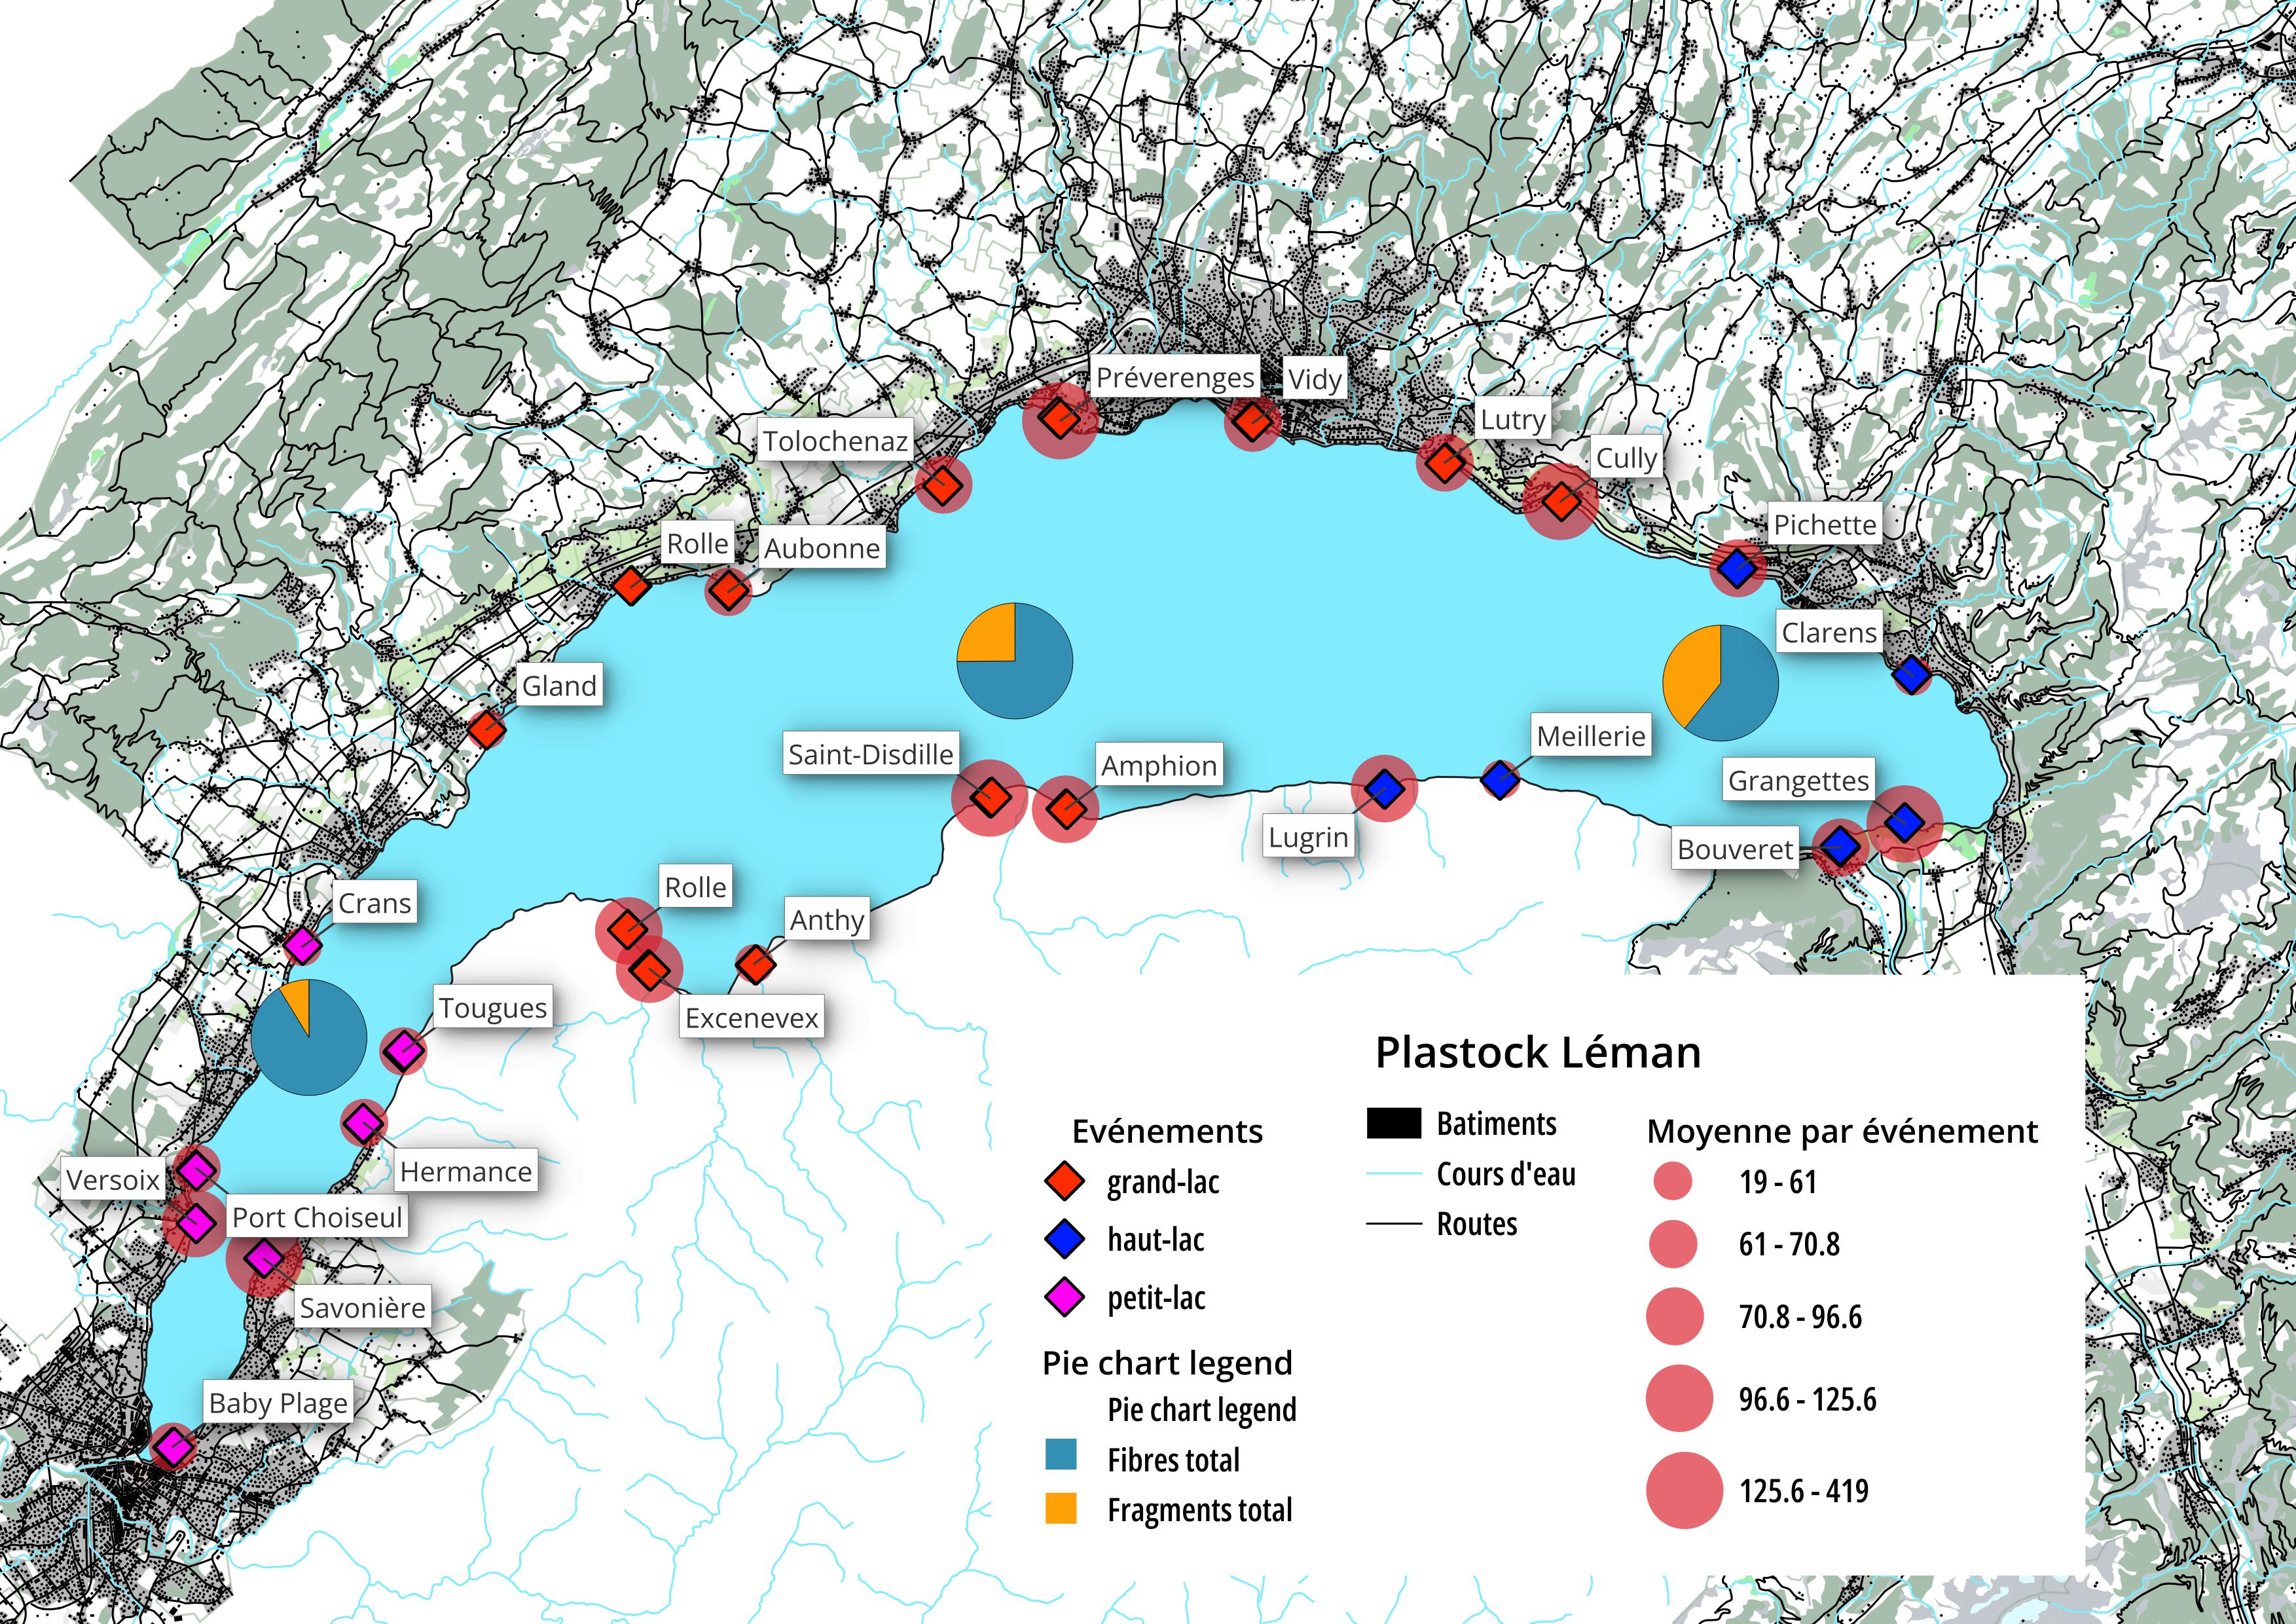

In [34]:
display.Image("data/images/vone_leman.jpg")

In [63]:
# survey results
wd = pd.read_csv("data/workDataTwo.csv")
# time and beach orientation
tAndO = pd.read_csv("data/timeOrientation.csv")

# work columns
m_labels = {1: "Sables fin", 2:"Sables grossiers", 3:"Graviers", 4:"Galets"}
id_vars = ["p", "E", "z", "m"]
value_vars = ["fibres", "fragments"]
columns={"p":"place", "E":"événement", "z":"zone", "m":"substrat", "value":"y", "variable":"matériel"}

regions = {
    'Hermance':"petit-lac",
    'Savonière': "petit-lac",
    'Baby Plage': "petit-lac",
    'Versoix': "petit-lac",
    'Crans':"petit-lac",
    'Gland':"grand-lac",
    'Rolle':"grand-lac",
    'Aubonne':"grand-lac",
    'Tolochenaz':"grand-lac",
    'Préverenges':"grand-lac",
    'Vidy':"grand-lac", 
    'Lutry':"grand-lac",
    'Cully':"grand-lac",
    'Pichette':"haut-lac",
    'Clarens': "haut-lac",
    'Grangettes':"haut-lac",
    'Bouveret':"haut-lac",
    'Tougues': "petit-lac",
    'Excenevex':"grand-lac",
    'Meillerie':"haut-lac",
    'Lugrin':"haut-lac",
    'Amphion':"grand-lac",
    'Anthy':"grand-lac",
    'Port Choiseul':"petit-lac",
    'Saint-Disdille':"grand-lac"   
}

# the cardinal directions for orientation of the beach
cardinal = {
    'OSO':247.5, 'NO': 315, 'NNE': 22.5, 'N':0, 'ESE':112.5, 'SSE':157.5, 'E':90, 'SSO':202.5, 'S':180, 'ONO':292.5, 'O':270,
       'SO':225, 'SE':135, 'ENE':67.5, 'NE':45, 'NNO': 337.5}

# new data in long form
lwd = pd.melt(wd, id_vars=id_vars, value_vars=value_vars)
lwd.rename(columns=columns, inplace=True)
lwd["région"] = lwd.place.map(lambda x: regions[x])
lwd["substrat"] = lwd.substrat.map(lambda x: m_labels[x])

# limit this to the water line
lwd = lwd[lwd.zone == "ligne-d'eau"].copy()
wd = wd[wd.z == "ligne-d'eau"].copy()

# convert time to ints from strings
tAndO["T"] = tAndO["T"].astype('int')
# map events to the orientation and time
omap = tAndO[["E", "O"]].set_index("E")
tmap = tAndO[["E", "T"]].set_index("E")

def timeMap(event: str="") -> int:
    return tmap.loc[event, "T"]
def oMap(event: str="") -> str:
    return omap.loc[event, "O"]
# add the orientation to the survey results
# and the long form data
wd["orientation"] = wd["E"].map(lambda x: oMap(x))
wd["temps"] = wd["E"].map(lambda x: timeMap(x))
wd["direction"] = wd.orientation.map(lambda x: cardinal[x])

# a total for each event
wd["total"] = wd["fibres"]+wd["fdure"] + wd["souple"]
wd.rename(columns={"p":"place", "E":"événement", "z":"zone", "m":"substrat", "value":"y", "variable":"matériel"}, inplace=True)
wd["région"] = wd.place.map(lambda x: regions[x])
lwd["orientation"] = lwd["événement"].map(lambda x: oMap(x))
lwd["temps"] = lwd["événement"].map(lambda x: timeMap(x))
lwd["direction"] = lwd.orientation.map(lambda x: cardinal[x])

# get the total for each event
event_totals = lwd.groupby("événement").y.sum()
# add a total column to the longform data
lwd["total"] = lwd["événement"].map(lambda x: event_totals.loc[x])
# the ratio of y to event total for each record
lwd["ratio"] = lwd["y"]/lwd["total"]

# check that lwd = wd
testOne = lwd.groupby("place").total.median() == wd.groupby("place").total.median()
testTwo = lwd[lwd["matériel"] == "fibres"].y.sum() == wd["fibres"].sum()

if not testTwo:
    print("fail")
if len(testOne) != testOne.sum():
    print("fail")

# posterior predictive results from first itteration
with open("data/fibersGePosteriorPredictive.json", "r") as afile:
    bi = json.load(afile)
with open("data/fragmentsGePosteriorPredictive.json", "r") as afile:
    ai = json.load(afile)
with open("data/totalGePosteriorPredictive.json", "r") as afile:
    totalPosterior = json.load(afile)    
with open("data/fibersVdPosteriorPredictive.json", "r") as afile:
    di = json.load(afile)
with open("data/fragmentsVdPosteriorPredictive.json", "r") as afile:
    ci = json.load(afile)
with open("data/totalVdPosteriorPredictive.json", "r") as afile:
    totalPosteriorvd = json.load(afile)

In [64]:
# add the GPS points to the set
latMap = tAndO[["E", "lat"]].set_index("E")
lonMap = tAndO[["E", "lon"]].set_index("E")

# 
wd["lat"] = wd["événement"].map(lambda x: latMap.loc[x, "lat"])
wd["lon"] = wd["événement"].map(lambda x: lonMap.loc[x, "lon"])
a = wd.groupby(["événement", "place", "orientation", "direction","lat", "lon", "région"], as_index=False).agg({'fragments':'sum', 'fibres':'sum', 'total':'sum'})

In [65]:
role = a[(a.place == "Rolle") & (a.lat == 46.361333)]
role["lat"] = 46.461333

not_rol = a[(~((a.place == "Rolle") & (a.lat == 46.361333)))]

a = pd.concat([not_rol, role])
plastock_micro_summary = a.groupby(["place", "orientation", "direction","lat", "lon", "région"], as_index=False).agg({'fragments':'sum', 'fibres':'sum', 'total':'sum'})
plastock_micro_summary.to_csv("data/plastock_micro_results.csv")

orientation_lat_map = plastock_micro_summary[["place","direction","lat", "lon"]].copy()
o_and_gps = orientation_lat_map.drop_duplicates("place")
o_and_gps.set_index("place", drop=True, inplace=True)
plastock_micro_summary.columns

Index(['place', 'orientation', 'direction', 'lat', 'lon', 'région',
       'fragments', 'fibres', 'total'],
      dtype='object')

In [66]:
pstock_reduced = plastock_micro_summary.groupby(["place", "région"], as_index=False).agg({'fragments':'sum', 'fibres':'sum', 'total':'sum'})
pstock_reduced["lat"] = pstock_reduced.place.map(lambda x: o_and_gps.loc[x, "lat"])
pstock_reduced["lon"] = pstock_reduced.place.map(lambda x: o_and_gps.loc[x, "lon"])
pstock_reduced['direction'] = pstock_reduced.place.map(lambda x: o_and_gps.loc[x, 'direction'])
pstock_reduced.to_csv("data/plastock_micro_results_reduced.csv")
pstock_reduced.place

0            Amphion
1              Anthy
2            Aubonne
3         Baby Plage
4           Bouveret
5            Clarens
6              Crans
7              Cully
8          Excenevex
9              Gland
10        Grangettes
11          Hermance
12            Lugrin
13             Lutry
14         Meillerie
15          Pichette
16     Port Choiseul
17       Préverenges
18             Rolle
19    Saint-Disdille
20         Savonière
21        Tolochenaz
22           Tougues
23           Versoix
24              Vidy
Name: place, dtype: object

### 1. Comptage moyen par événement, type de fragement et par orientation sur *ligne-d'eau*

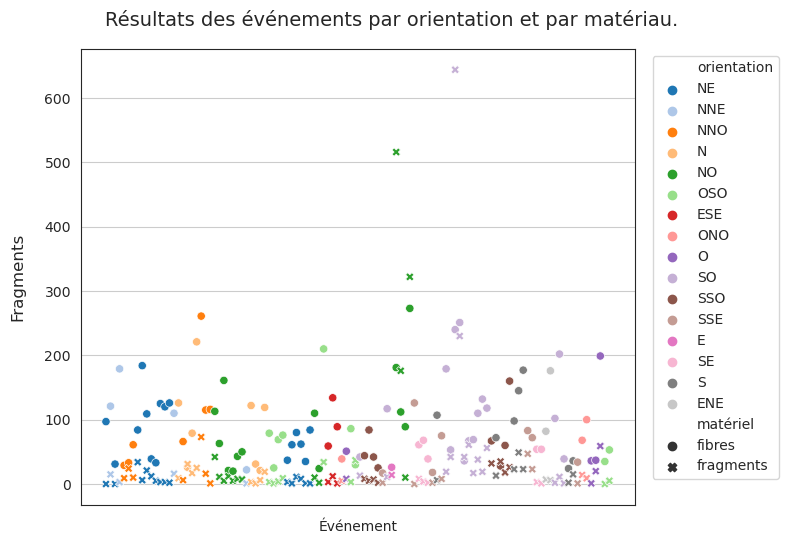

In [4]:
a_df= lwd.groupby(["événement","orientation", "matériel"], as_index=False)["y"].sum()
order = [ 'E','ENE', 'NE','NNE','N', 'NO', 'NNO', 'ONO',  'O', 'OSO',  'SSO', 'SO',  'S','SSE', 'ESE', 'SE']

fig, ax = plt.subplots(figsize=(8,5.5))
ax = sns.scatterplot(data=a_df, x="événement", y="y", hue="orientation", palette='tab20', style="matériel")
ax.xaxis.set_ticklabels([])

ax.set_xlabel("Événement")
ax.set_ylabel("Fragments", fontsize=12, labelpad=14)
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
ax.grid(axis="y")

plt.suptitle("Résultats des événements par orientation et par matériau. ", fontsize=14, y=.98)
plt.tight_layout()

plt.show()

In [18]:
a_df

,événement,orientation,y
0,74_Amp_1,NE,97.0
1,74_Amp_2,NNE,136.0
2,74_Amp_3,NE,31.0
3,74_Amp_4,NNE,182.0
4,74_Ant_1,NNO,38.0
...,...,...,...
107,VS_Bou_3,O,37.0
108,VS_Bou_4,O,57.0
109,VS_Bou_5,O,258.0
110,VS_Bou_6,OSO,35.0


In [5]:
f = f""" 
Le nombre moyen de particules par orientation et matériel

Note: mean=moyenne, 'événement-nunique'= nombre de prélèvements, 'place-nunique'= nombre de plages
\n

{lwd.groupby(["orientation","matériel"]).agg({"y":["mean", "median"], "événement":"nunique", "place":"nunique"})}

"""
print(f)

 
Le nombre moyen de particules par orientation et matériel

Note: mean=moyenne, 'événement-nunique'= nombre de prélèvements, 'place-nunique'= nombre de plages



                                y        événement   place
                             mean median   nunique nunique
orientation matériel                                      
E           fibres      26.000000   26.0         1       1
            fragments   14.000000   14.0         1       1
ENE         fibres     129.000000  129.0         2       1
            fragments    6.500000    6.5         2       1
ESE         fibres      94.000000   89.0         3       1
            fragments    5.333333    3.0         3       1
N           fibres      93.125000   99.0         8       4
            fragments   13.875000   13.0         8       4
NE          fibres      81.687500   82.0        16       3
            fragments    6.937500    3.0        16       3
NNE         fibres     108.000000  115.5         4       3
           

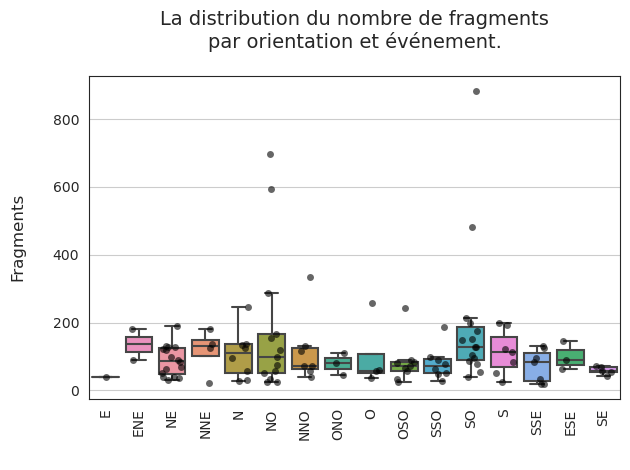

In [6]:
# # total per event by place
a_df= lwd.groupby(["événement", "orientation"], as_index=False)["y"].sum()


fig, ax = plt.subplots()

sns.boxplot(data=a_df, x="orientation", y="y", hue="orientation", ax=ax, order=order, width=.8, dodge=False, showfliers=False)
sns.stripplot(data=a_df, x="orientation", y="y", color="black", ax=ax, order=order, jitter=.3, alpha=.6)
ax.tick_params(axis="x", which="both", labelrotation=90)
ax.set_ylabel("Fragments", fontsize=12, labelpad=20)
ax.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=6).remove()
ax.set_title("La distribution du nombre de fragments\npar orientation et événement.", fontsize=14, pad=20)
ax.set_xlabel(" ")
ax.margins(x=.9, y=None)
ax.grid(axis="y")
plt.tight_layout()
plt.show()

#### Résultats par orientation

In [7]:
f = f""" 
Le nombre moyen de particules par orientation

Note: mean=moyenne, 'événement-nunique'= nombre de prélèvements, 'place-nunique'= nombre de plages
\n

{lwd.groupby('orientation', as_index=False).agg({"total":["mean", "median"], "événement":"nunique", "place":"nunique"})}

"""
print(f)

 
Le nombre moyen de particules par orientation

Note: mean=moyenne, 'événement-nunique'= nombre de prélèvements, 'place-nunique'= nombre de plages



   orientation       total        événement   place
                      mean median   nunique nunique
0            E   40.000000   40.0         1       1
1          ENE  135.500000  135.5         2       1
2          ESE   99.333333   90.0         3       1
3            N  107.000000  110.5         8       4
4           NE   88.625000   88.0        16       3
5          NNE  116.750000  131.0         4       3
6          NNO  117.142857   72.0         7       3
7           NO  183.538462   99.0        13       4
8            O  102.750000   58.0         4       2
9          ONO   78.333333   82.0         3       2
10         OSO   84.333333   73.0         9       4
11           S  112.857143  113.0         7       3
12          SE   58.800000   57.0         5       2
13          SO  197.533333  128.0        15       4
14         SSE   

In [8]:
placeOrientation = wd.groupby(["place", "orientation"]).agg({"total":["mean", "median"], "événement":"nunique"})
f = f""" 
Le nombre moyen de particules par place et orientation

Note: mean=moyenne, 'événement-nunique'= nombre de prélèvements
\n

{placeOrientation}

"""
print(f)

 
Le nombre moyen de particules par place et orientation

Note: mean=moyenne, 'événement-nunique'= nombre de prélèvements



                                 total        événement
                                  mean median   nunique
place          orientation                             
Amphion        NE            64.000000   64.0         2
               NNE          159.000000  159.0         2
Anthy          NNO           55.333333   57.0         3
Aubonne        O             59.000000   59.0         1
               ONO           44.000000   44.0         1
               OSO           78.000000   78.0         2
               SO            55.000000   55.0         1
Baby Plage     N             80.500000   78.5         4
               NNE           23.000000   23.0         1
Bouveret       O            117.333333   57.0         3
               ONO           95.500000   95.5         2
               OSO           46.500000   46.5         2
Clarens        SSO           54.250

## Export GIS

La latitude et la longitude sont ajoutées aux données, ainsi que tout identifiant régional. Les données sont exportées dans un fichier .CSV et peuvent être utilisées dans des applications SIG comme données de référence.

In [12]:
# add the GPS points to the set
latMap = tAndO[["E", "lat"]].set_index("E")
lonMap = tAndO[["E", "lon"]].set_index("E")

# 
wd["lat"] = wd["événement"].map(lambda x: latMap.loc[x, "lat"])
wd["lon"] = wd["événement"].map(lambda x: lonMap.loc[x, "lon"])
wd.to_csv('data/gisData.csv', index=False)

placeLabels = wd[["place", "lat", "lon"]].copy()
placeLabels.lat = placeLabels.lat.round(3)
placeLabels.lon = placeLabels.lon.round(3)
placeLabels = placeLabels.drop_duplicates('place', keep='first')
placeLabels.to_csv("data/placeLabels.csv", index=False)

placeGPSMapLat = placeLabels.set_index("place")
summaryByPlace = wd.groupby("place", as_index=False).agg({"fibres":"sum", "fragments":"sum", "temps":"sum", "total":"mean"})
summaryByPlace["lat"] = summaryByPlace.place.map(lambda x: placeGPSMapLat.loc[x, "lat"])
summaryByPlace["lon"] = summaryByPlace.place.map(lambda x: placeGPSMapLat.loc[x, "lon"])
summaryByPlace["moyenne"] = summaryByPlace["total"].astype("int")
summaryByPlace["fibres"] = summaryByPlace["fibres"].astype("int")
summaryByPlace["fragments"] = summaryByPlace["fragments"].astype("int")
summaryByPlace.to_csv("data/gisSupport.csv", index=False)

In [14]:
len(wd.groupby("place").fragments.sum())

25

In [17]:
summaryByPlace

,place,fibres,fragments,temps,total,lat,lon,moyenne
0,Amphion,428,18,200,111.500000,46.398,6.534,111
1,Anthy,123,43,90,55.333333,46.352,6.404,55
2,Aubonne,248,66,200,62.800000,46.460,6.391,62
3,Baby Plage,315,30,300,69.000000,46.209,6.163,69
4,Bouveret,528,108,350,90.857143,46.389,6.860,90
5,Clarens,195,22,120,54.250000,46.439,6.890,54
6,Crans,17,2,6,19.000000,46.355,6.214,19
7,Cully,117,11,7,128.000000,46.489,6.741,128
8,Excenevex,820,86,720,113.250000,46.350,6.360,113
9,Gland,26,14,8,40.000000,46.419,6.290,40
